In [ ]:
import zipfile
import os

# Path to the uploaded zip file and extraction folder
zip_path = '/content/archive.zip'
extraction_folder = '/content/extracted_dataset/'

# Extract the uploaded zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

# List the extracted files to check the contents
os.listdir(extraction_folder)


['manufacturing_defect_dataset.csv']

In [ ]:
import pandas as pd

# Load the dataset
file_path = os.path.join(extraction_folder, 'manufacturing_defect_dataset.csv')
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
dataset.head(), dataset.info(), dataset.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductionVolume      3240 non-null   int64  
 1   ProductionCost        3240 non-null   float64
 2   SupplierQuality       3240 non-null   float64
 3   DeliveryDelay         3240 non-null   int64  
 4   DefectRate            3240 non-null   float64
 5   QualityScore          3240 non-null   float64
 6   MaintenanceHours      3240 non-null   int64  
 7   DowntimePercentage    3240 non-null   float64
 8   InventoryTurnover     3240 non-null   float64
 9   StockoutRate          3240 non-null   float64
 10  WorkerProductivity    3240 non-null   float64
 11  SafetyIncidents       3240 non-null   int64  
 12  EnergyConsumption     3240 non-null   float64
 13  EnergyEfficiency      3240 non-null   float64
 14  AdditiveProcessTime   3240 non-null   float64
 15  AdditiveMaterialCost 

(   ProductionVolume  ProductionCost  SupplierQuality  DeliveryDelay  \
 0               202    13175.403783        86.648534              1   
 1               535    19770.046093        86.310664              4   
 2               960    19060.820997        82.132472              0   
 3               370     5647.606037        87.335966              5   
 4               206     7472.222236        81.989893              3   
 
    DefectRate  QualityScore  MaintenanceHours  DowntimePercentage  \
 0    3.121492     63.463494                 9            0.052343   
 1    0.819531     83.697818                20            4.908328   
 2    4.514504     90.350550                 1            2.464923   
 3    0.638524     67.628690                 8            4.692476   
 4    3.867784     82.728334                 9            2.746726   
 
    InventoryTurnover  StockoutRate  WorkerProductivity  SafetyIncidents  \
 0           8.630515      0.081322           85.042379             

<Axes: >

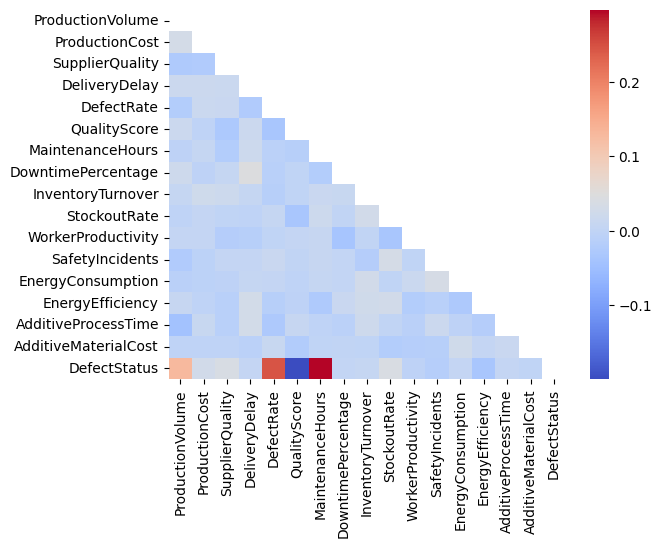

In [ ]:
import seaborn as sns

corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = cmap)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Split the dataset into features and target
X = dataset.drop(columns=['DefectStatus'])
y = dataset['DefectStatus']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a basic Random Forest model to establish a baseline
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

baseline_accuracy, baseline_f1


(0.9506172839506173, 0.9712746858168761)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split a node
}

# Initialize the GridSearchCV for Random Forest
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=100), param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

# Best parameters and their corresponding score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

best_params, best_f1_score


Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'max_depth': 20, 'min_samples_split': 2}, 0.9774717253027955)

In [ ]:
random_forest_model = RandomForestClassifier(min_samples_split = 10, max_depth = 10, random_state = 100).fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
print(f"Random forest model accuracy: {accuracy_score(y_test,y_pred):.3f}")

Random forest model accuracy: 0.951


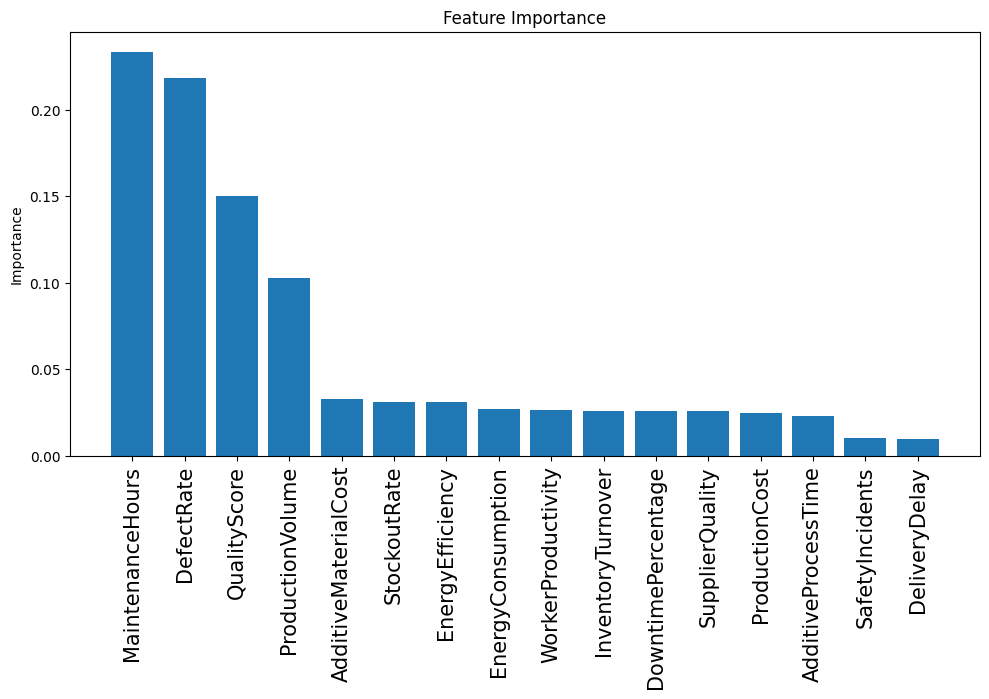

In [ ]:
import matplotlib.pyplot as plt

# Feature Importance from Random Forest
feature_importances = rf_model.feature_importances_
features = X.columns

# Combine features and their importances into a DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.xticks(rotation=90, fontsize=15)
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train an XGBoost Model with Early Stopping
xgb_model = xgb.XGBClassifier(random_state=100, use_label_encoder=False, eval_metric='logloss', learning_rate=0.1,early_stopping_rounds=25, n_estimators=500)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Predictions and Evaluation
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Classification Report for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report for XGBoost:\n", report_xgb)


[0]	validation_0-logloss:0.39242
[1]	validation_0-logloss:0.35698
[2]	validation_0-logloss:0.33004
[3]	validation_0-logloss:0.30894
[4]	validation_0-logloss:0.29134
[5]	validation_0-logloss:0.27733
[6]	validation_0-logloss:0.26540
[7]	validation_0-logloss:0.25512
[8]	validation_0-logloss:0.24705
[9]	validation_0-logloss:0.24046
[10]	validation_0-logloss:0.23393
[11]	validation_0-logloss:0.22952
[12]	validation_0-logloss:0.22556
[13]	validation_0-logloss:0.22240
[14]	validation_0-logloss:0.21955
[15]	validation_0-logloss:0.21737
[16]	validation_0-logloss:0.21575
[17]	validation_0-logloss:0.21477
[18]	validation_0-logloss:0.21345
[19]	validation_0-logloss:0.21222


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.21197
[21]	validation_0-logloss:0.21136
[22]	validation_0-logloss:0.21103
[23]	validation_0-logloss:0.21122
[24]	validation_0-logloss:0.21109
[25]	validation_0-logloss:0.21155
[26]	validation_0-logloss:0.21092
[27]	validation_0-logloss:0.21169
[28]	validation_0-logloss:0.21186
[29]	validation_0-logloss:0.21295
[30]	validation_0-logloss:0.21275
[31]	validation_0-logloss:0.21279
[32]	validation_0-logloss:0.21376
[33]	validation_0-logloss:0.21476
[34]	validation_0-logloss:0.21604
[35]	validation_0-logloss:0.21698
[36]	validation_0-logloss:0.21764
[37]	validation_0-logloss:0.21864
[38]	validation_0-logloss:0.21935
[39]	validation_0-logloss:0.22085
[40]	validation_0-logloss:0.22169
[41]	validation_0-logloss:0.22244
[42]	validation_0-logloss:0.22318
[43]	validation_0-logloss:0.22371
[44]	validation_0-logloss:0.22455
[45]	validation_0-logloss:0.22552
[46]	validation_0-logloss:0.22654
[47]	validation_0-logloss:0.22775
[48]	validation_0-logloss:0.22828
[49]	validatio